### Adoption

In [1]:
# =========================
# Cell 1 — Imports & Setup
# =========================

import numpy as np
import pandas as pd
from pathlib import Path

# Matplotlib for plots (optional but recommended)
try:
    import matplotlib.pyplot as plt
    MAKE_PLOTS = True
except Exception:
    MAKE_PLOTS = False

# Show more columns when printing DataFrames
pd.set_option("display.max_columns", 100)


In [5]:
# ======================================
# Cell 2 — Basic Config (edit as needed)
# ======================================

# Path to your input CSV (must include "Past Adoption Of AI tools")
INPUT_CSV = "Adoption_new.csv"

# Where outputs (CSVs and plots) should be saved
OUTDIR = Path("outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

# Forecast window
START_YEAR = 2025
HORIZON_YEARS = 8                  # Years: 2025..2032

# Adoption scenarios (logistic S-curve parameters)
# These are the simple, "plausible" defaults. Adjust to taste.
SCENARIOS = {
    "Pessimistic": {"K": 40,  "r": 0.8, "t0": 3},
    "Moderate":    {"K": 70,  "r": 1.0, "t0": 3},
    "Optimistic":  {"K": 100, "r": 1.2, "t0": 3},
}

# Weights for the propensity score (sum to 1.0).
# We assume your dataset always has the Past-AI column; it gets a clear weight.
WEIGHTS = {
    "scans": 0.30,
    "machines": 0.20,
    "university": 0.10,
    "past_ai": 0.15,
    "wait_list": 0.10,
    "wait_6w": 0.05,
    "delay_pct": 0.05,
    "req_to_test": 0.03,
    "test_to_report": 0.02,
}


In [6]:
# ==========================================
# Cell 3 — Helper functions (kept minimal)
# ==========================================

def robust_scale(series: pd.Series) -> pd.Series:
    """
    Robust scaling: (x - median) / IQR.
    Reduces outlier influence and keeps all features comparable.
    """
    s = pd.to_numeric(series, errors="coerce")
    med = s.median()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    if iqr and iqr != 0:
        out = (s - med) / iqr
    else:
        std = s.std(ddof=0)
        out = (s - med) / std if (std and std != 0) else pd.Series(0.0, index=s.index)
    return out.fillna(0.0)

def minmax_0_100(series: pd.Series) -> pd.Series:
    """
    Map a series to a 0–100 index for easy interpretation and ranking.
    """
    s = series.astype(float)
    lo, hi = s.min(), s.max()
    if hi == lo:
        return pd.Series(50.0, index=s.index)  # flat if all equal
    return 100.0 * (s - lo) / (hi - lo)

def logistic_cumulative_array(T: int, K: int, r: float, t0: float) -> np.ndarray:
    """
    Vectorized logistic cumulative:
    cum(t) = K / (1 + exp(-r * (t - t0))) for t = 0..T-1
    """
    t = np.arange(T, dtype=float)
    return K / (1.0 + np.exp(-r * (t - t0)))


In [8]:
# ============================================
# Cell 4 — Load, clean, and compute the scores
# ============================================

# Load CSV
df = pd.read_csv(INPUT_CSV)

# EXPECTED COLUMN NAMES (edit here if yours differ):
COL_PROVIDER        = "Provider name"
COL_UNIVERSITY      = "University Hopsital (Yes-1/No-0)"   # 1/0 flag
COL_PAST_AI         = "Past Adoption Of AI tools"           # "Yes"/"No"
COL_SCANS           = "No of MRI Prostate Scans(5% of total)"
COL_MACHINES        = "No of Machines"
COL_WAIT_LIST       = "Total Prostate MRI waiting List"
COL_WAIT_6W         = "Prostate MRI waiting 6+weeks"
COL_DELAY_PCT       = "6+ weeks delay %"
COL_REQ_TO_TEST     = "Median no of Days from test request to test"
COL_TEST_TO_REPORT  = "Median no of Days from test  to test report"

# Basic cleaning
for c in [COL_SCANS, COL_MACHINES, COL_WAIT_LIST, COL_WAIT_6W, COL_DELAY_PCT, COL_REQ_TO_TEST, COL_TEST_TO_REPORT]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(df[c].median())

df[COL_UNIVERSITY] = pd.to_numeric(df[COL_UNIVERSITY], errors="coerce").fillna(0).clip(lower=0, upper=1)
df["Past_AI_Adoption_Flag"] = (
    df[COL_PAST_AI]
    .astype(str)
    .str.strip()  # FIX: use .str.strip() instead of .strip()
    .str.lower()
    .map({"yes": 1, "no": 0})
    .fillna(0)
    .astype(int)
)


# Build scaled features (direction: higher -> more likely to adopt)
scaled = pd.DataFrame(index=df.index)
scaled["scans_z"]          = robust_scale(df[COL_SCANS])
scaled["machines_z"]       = robust_scale(df[COL_MACHINES])
scaled["university_bin"]   = df[COL_UNIVERSITY].astype(float)
scaled["past_ai_bin"]      = df["Past_AI_Adoption_Flag"].astype(float)
scaled["wait_list_z"]      = robust_scale(df[COL_WAIT_LIST])
scaled["wait_6w_z"]        = robust_scale(df[COL_WAIT_6W])
scaled["delay_pct_z"]      = robust_scale(df[COL_DELAY_PCT])
scaled["req_to_test_z"]    = robust_scale(df[COL_REQ_TO_TEST])
scaled["test_to_report_z"] = robust_scale(df[COL_TEST_TO_REPORT])

# Weighted raw score (linear index)
raw_score = (
    WEIGHTS["scans"]        * scaled["scans_z"] +
    WEIGHTS["machines"]     * scaled["machines_z"] +
    WEIGHTS["university"]   * scaled["university_bin"] +
    WEIGHTS["past_ai"]      * scaled["past_ai_bin"] +
    WEIGHTS["wait_list"]    * scaled["wait_list_z"] +
    WEIGHTS["wait_6w"]      * scaled["wait_6w_z"] +
    WEIGHTS["delay_pct"]    * scaled["delay_pct_z"] +
    WEIGHTS["req_to_test"]  * scaled["req_to_test_z"] +
    WEIGHTS["test_to_report"] * scaled["test_to_report_z"]
)

# Convert to 0–100 index and build ranking
index_0_100 = minmax_0_100(raw_score)

ranked = pd.DataFrame({
    "Provider": df[COL_PROVIDER],
    "PropensityRaw": raw_score.round(6),
    "PropensityIndex": index_0_100.round(2),
    "UniversityHospital": df[COL_UNIVERSITY].astype(int),
    "PastAIAdoption": df["Past_AI_Adoption_Flag"].astype(int),
    "MRI_Prostate_Scans": df[COL_SCANS],
    "MRI_Machines": df[COL_MACHINES],
    "Waiting_List": df[COL_WAIT_LIST],
    "Waiting_6w_plus": df[COL_WAIT_6W],
    "Delay_6wPlus_Pct": df[COL_DELAY_PCT],
    "MedianDays_Request_to_Test": df[COL_REQ_TO_TEST],
    "MedianDays_Test_to_Report": df[COL_TEST_TO_REPORT],
}).sort_values(["PropensityIndex", "PropensityRaw"], ascending=False).reset_index(drop=True)

ranked.insert(0, "Rank", np.arange(1, len(ranked) + 1))

# Save and preview
ranked_path = OUTDIR / "propensity_scores_ranked.csv"
ranked.to_csv(ranked_path, index=False)

display(ranked.head(15))
print(f"Saved ranked propensity scores -> {ranked_path.resolve()}")


,Rank,Provider,PropensityRaw,PropensityIndex,UniversityHospital,PastAIAdoption,MRI_Prostate_Scans,MRI_Machines,Waiting_List,Waiting_6w_plus,Delay_6wPlus_Pct,MedianDays_Request_to_Test,MedianDays_Test_to_Report
0,1,Guy's and St Thomas' NHS Foundation Trust,2.289157,100.00,0,1,4273,15,5280,2470,47,38,5
1,2,East Kent Hospitals University NHS Foundation ...,1.638827,77.37,1,1,4060,7,4885,1231,25,35,5
2,3,University Hospitals Birmingham NHS Foundation...,1.606003,76.22,1,1,4821,12,3150,211,7,21,6
3,4,University Hospitals of Leicester NHS Trust,1.565845,74.83,1,0,3163,10,5153,1698,33,41,5
4,5,Northern Care Alliance NHS Foundation Trust,1.552712,74.37,0,1,4526,14,3491,91,3,31,7
5,6,Barts Health NHS Trust,1.533585,73.70,0,1,3640,9,4302,1406,33,32,6
6,7,Imperial College Healthcare NHS Trust,1.424742,69.92,0,1,4371,12,2618,350,13,30,7
7,8,Nottingham University Hospitals NHS Trust,1.422330,69.83,1,1,3297,12,2768,930,34,28,2
8,9,University Hospitals Sussex NHS Foundation Trust,1.344735,67.13,1,1,3811,12,1942,443,23,15,7
9,10,Manchester University NHS Foundation Trust,1.343246,67.08,1,1,2986,8,3737,1179,32,25,9


Saved ranked propensity scores -> C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\outputs\propensity_scores_ranked.csv


In [9]:
# ==========================================
# Cell 5 — Simulate adoption (logistic S-curve)
# ==========================================

years = list(range(START_YEAR, START_YEAR + HORIZON_YEARS))
total_trusts = len(ranked)

def scenario_curve(years: list[int], K: int, r: float, t0: float, cap: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Convert a logistic curve into:
    - cumulative adopters per year (integers, capped at market size)
    - new adopters per year (differences of cumulative)
    """
    T = len(years)
    cum = logistic_cumulative_array(T, K, r, t0)
    cum = np.clip(np.round(cum).astype(int), 0, cap)  # round to integers
    cum = np.maximum.accumulate(cum)                  # enforce non-decreasing
    cum[-1] = min(cum[-1], cap)                       # cap at total trusts
    new = np.diff(np.insert(cum, 0, 0))
    return cum, new

schedules = {}
assignments = {}

for name, params in SCENARIOS.items():
    # Build yearly cumulative and new adopter counts
    cum, new = scenario_curve(years, params["K"], params["r"], params["t0"], cap=total_trusts)
    schedules[name] = pd.DataFrame({"Year": years, "New_Adopters": new, "Cumulative_Adopters": cum})

    # Assign trusts to years by descending propensity rank
    rows = []
    cursor = 0
    for y, n in zip(years, new):
        if n <= 0:
            continue
        end = min(cursor + n, total_trusts)
        batch = ranked.loc[cursor:end-1, ["Provider", "PropensityIndex"]].copy()
        batch["AdoptionYear"] = y
        batch["Scenario"] = name
        rows.append(batch)
        cursor = end
    assignments[name] = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(
        columns=["Provider", "PropensityIndex", "AdoptionYear", "Scenario"]
    )

# Combine for output
schedule_all = pd.concat([v.assign(Scenario=k) for k, v in schedules.items()], ignore_index=True)
assign_all   = pd.concat(assignments.values(), ignore_index=True)

# Save and preview
schedule_path = OUTDIR / "adoption_schedules.csv"
assign_path   = OUTDIR / "trust_adoption_assignments.csv"
schedule_all.to_csv(schedule_path, index=False)
assign_all.to_csv(assign_path, index=False)

display(schedule_all.groupby("Scenario").head(5))   # quick look
display(assign_all.groupby("Scenario").head(15))    # first 15 per scenario

print(f"Saved yearly schedules           -> {schedule_path.resolve()}")
print(f"Saved trust adoption assignments -> {assign_path.resolve()}")


,Year,New_Adopters,Cumulative_Adopters,Scenario
0,2025,3,3,Pessimistic
1,2026,4,7,Pessimistic
2,2027,5,12,Pessimistic
3,2028,8,20,Pessimistic
4,2029,8,28,Pessimistic
8,2025,3,3,Moderate
9,2026,5,8,Moderate
10,2027,11,19,Moderate
11,2028,16,35,Moderate
12,2029,16,51,Moderate


,Provider,PropensityIndex,AdoptionYear,Scenario
0,Guy's and St Thomas' NHS Foundation Trust,100.00,2025,Pessimistic
1,East Kent Hospitals University NHS Foundation ...,77.37,2025,Pessimistic
2,University Hospitals Birmingham NHS Foundation...,76.22,2025,Pessimistic
3,University Hospitals of Leicester NHS Trust,74.83,2026,Pessimistic
4,Northern Care Alliance NHS Foundation Trust,74.37,2026,Pessimistic
5,Barts Health NHS Trust,73.70,2026,Pessimistic
6,Imperial College Healthcare NHS Trust,69.92,2026,Pessimistic
7,Nottingham University Hospitals NHS Trust,69.83,2027,Pessimistic
8,University Hospitals Sussex NHS Foundation Trust,67.13,2027,Pessimistic
9,Manchester University NHS Foundation Trust,67.08,2027,Pessimistic


Saved yearly schedules           -> C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\outputs\adoption_schedules.csv
Saved trust adoption assignments -> C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\outputs\trust_adoption_assignments.csv


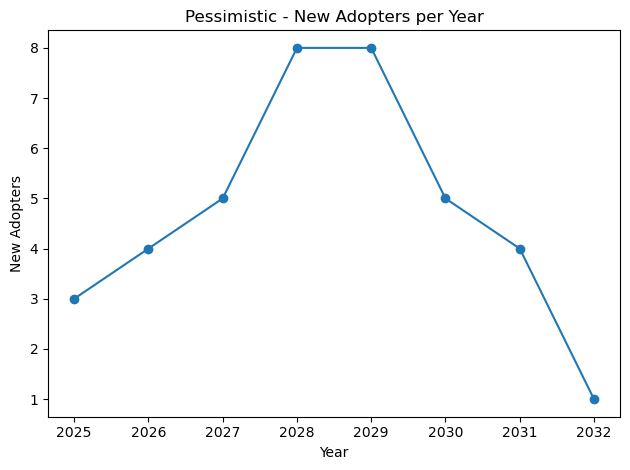

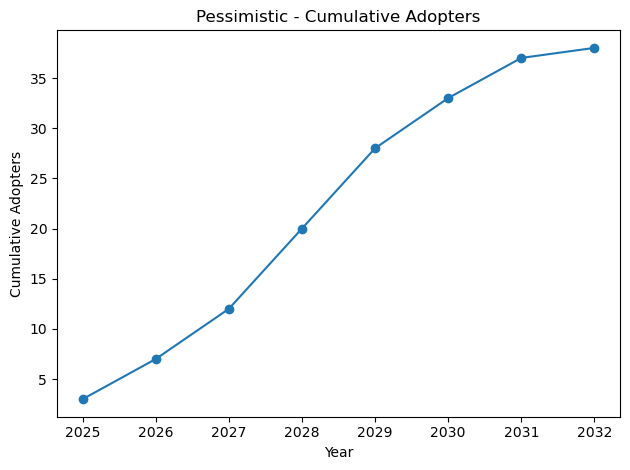

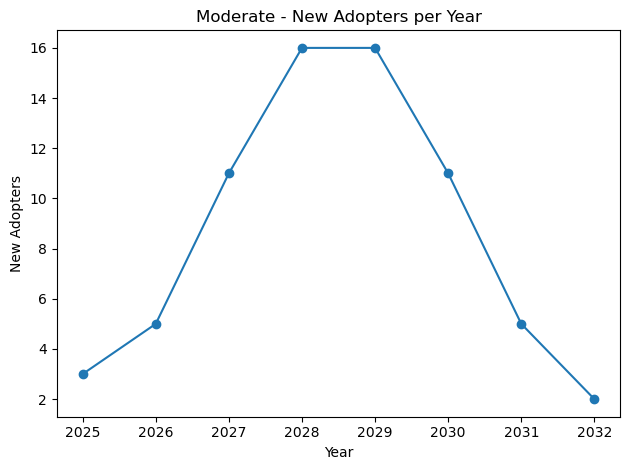

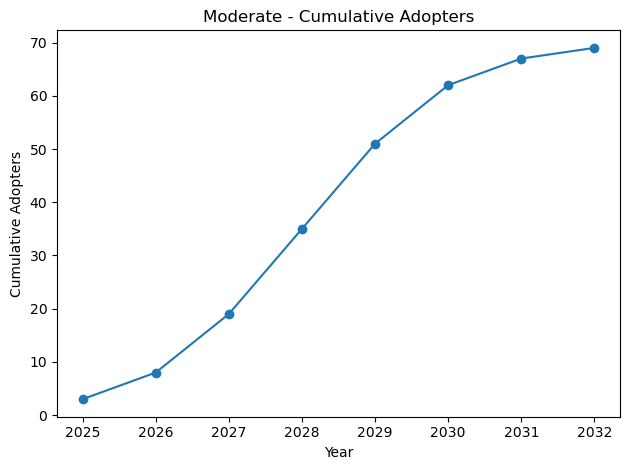

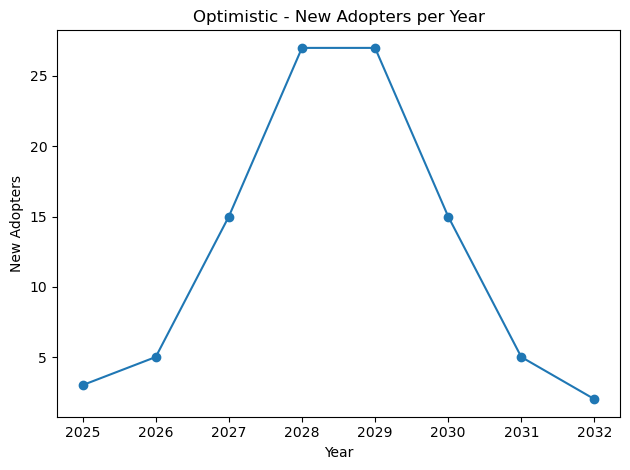

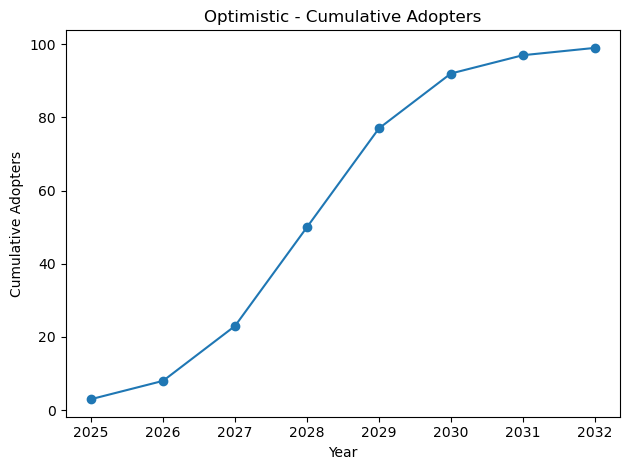

Plots saved to: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\outputs


In [10]:
# ====================================
# Cell 6 — Plots (optional but useful)
# ====================================

if MAKE_PLOTS:
    # On-screen plots
    for scenario in schedule_all["Scenario"].unique():
        dfc = schedule_all[schedule_all["Scenario"] == scenario].copy()

        # New adopters per year
        plt.figure()
        plt.plot(dfc["Year"], dfc["New_Adopters"], marker="o")
        plt.title(f"{scenario} - New Adopters per Year")
        plt.xlabel("Year")
        plt.ylabel("New Adopters")
        plt.tight_layout()
        plt.show()

        # Cumulative adopters
        plt.figure()
        plt.plot(dfc["Year"], dfc["Cumulative_Adopters"], marker="o")
        plt.title(f"{scenario} - Cumulative Adopters")
        plt.xlabel("Year")
        plt.ylabel("Cumulative Adopters")
        plt.tight_layout()
        plt.show()

    # Save PNGs
    for scenario in schedule_all["Scenario"].unique():
        dfc = schedule_all[schedule_all["Scenario"] == scenario].copy()

        fig1 = plt.figure()
        plt.plot(dfc["Year"], dfc["New_Adopters"], marker="o")
        plt.title(f"{scenario} - New Adopters per Year")
        plt.xlabel("Year")
        plt.ylabel("New Adopters")
        plt.tight_layout()
        p1 = OUTDIR / f"{scenario.replace(' ', '_').lower()}_new_adopters.png"
        fig1.savefig(p1, dpi=150)
        plt.close(fig1)

        fig2 = plt.figure()
        plt.plot(dfc["Year"], dfc["Cumulative_Adopters"], marker="o")
        plt.title(f"{scenario} - Cumulative Adopters")
        plt.xlabel("Year")
        plt.ylabel("Cumulative Adopters")
        plt.tight_layout()
        p2 = OUTDIR / f"{scenario.replace(' ', '_').lower()}_cumulative_adopters.png"
        fig2.savefig(p2, dpi=150)
        plt.close(fig2)

    print("Plots saved to:", OUTDIR.resolve())
else:
    print("Matplotlib not available; skipping plots.")
